In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
scaler = StandardScaler()
data = pd.read_csv('data.csv')
data_validation = pd.read_csv('validation.csv')
data_validation_1 = data_validation.drop(columns=['sub_H','sub_B','yield'])
model = SVR(C= 154.01240128578291, epsilon= 0.019791697299111212, kernel= 'rbf')
data1 = data[['delta_G_B', 'dipole_H', 'homo_B', 'Mulliken_charge_H_H', 'NPA_charge_H_H','yield']]
display(data1)
display(data_validation_1)

,delta_G_B,dipole_H,homo_B,Mulliken_charge_H_H,NPA_charge_H_H,yield
0,14.2,0.6974,-0.28457,0.045540,0.21569,95
1,9.7,0.6974,-0.28379,0.045540,0.21569,70
2,6.2,0.6974,-0.28448,0.045540,0.21569,8
3,9.5,0.6974,-0.29832,0.045540,0.21569,90
4,14.2,2.4913,-0.28457,0.032127,0.22098,35
...,...,...,...,...,...,...
70,6.2,0.1736,-0.28448,0.011676,0.23558,2
71,6.2,0.0879,-0.28448,0.011909,0.23731,2
72,6.2,1.9335,-0.28448,0.016165,0.24600,0
73,6.2,1.8518,-0.28448,-0.006066,0.22827,2


,delta_G_B,dipole_H,homo_B,Mulliken_charge_H_H,NPA_charge_H_H
0,14.2,0.6974,-0.28457,0.045540,0.21569
1,9.7,0.6974,-0.28379,0.045540,0.21569
2,6.2,0.6974,-0.28448,0.045540,0.21569
3,9.5,0.6974,-0.29832,0.045540,0.21569
4,14.2,2.4913,-0.28457,0.032127,0.22098
...,...,...,...,...,...
315,9.5,0.0836,-0.29832,0.036745,0.26459
316,14.2,2.4496,-0.28457,0.036895,0.21915
317,9.7,2.4496,-0.28379,0.036895,0.21915
318,6.2,2.4496,-0.28448,0.036895,0.21915


In [2]:


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


features = data1.select_dtypes(include=[np.number]).columns
X = data1[features].drop('yield', axis=1)
y = data1['yield']
y_pred_list = []
mse_list = []  
scaler = StandardScaler()

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    
    data_validation_scaled = scaler.transform(data_validation_1)
    y_pred = model.predict(data_validation_scaled)
    y_pred_list.append(y_pred)
    
    y_test_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_test_pred)
    mse_list.append(mse)

y_pred_array = np.array(y_pred_list)

# Calculate the weights, using the inverse of the mean square error
weights = 1 / np.array(mse_list)
weights /= np.sum(weights)  # Normalized weights

# Calculate weighted average forecast
y_pred_weighted = np.dot(weights, y_pred_array)

# Add y_pred as a new column to data_validation
data_validation_1['y_pred_mean'] = y_pred_weighted
data_validation_1 = pd.concat([data_validation[['sub_H', 'sub_B']], data_validation_1], axis=1)
display(data_validation_1)

data_validation_1.to_csv('data_validation_weighted_mean.csv', index=False)


,sub_H,sub_B,delta_G_B,dipole_H,homo_B,Mulliken_charge_H_H,NPA_charge_H_H,y_pred_mean
0,1,2a,14.2,0.6974,-0.28457,0.045540,0.21569,87.198405
1,1,2b,9.7,0.6974,-0.28379,0.045540,0.21569,68.233444
2,1,2c,6.2,0.6974,-0.28448,0.045540,0.21569,11.179675
3,1,2d,9.5,0.6974,-0.29832,0.045540,0.21569,57.115118
4,2,2a,14.2,2.4913,-0.28457,0.032127,0.22098,38.467179
...,...,...,...,...,...,...,...,...
315,79,2d,9.5,0.0836,-0.29832,0.036745,0.26459,30.140767
316,80,2a,14.2,2.4496,-0.28457,0.036895,0.21915,45.872219
317,80,2b,9.7,2.4496,-0.28379,0.036895,0.21915,80.064892
318,80,2c,6.2,2.4496,-0.28448,0.036895,0.21915,63.024736


In [3]:
df1 = pd.read_csv('data_validation_weighted_mean.csv')
df2 = pd.read_csv('../../final.csv')

# Ensure that both DataFrames have sub_H and sub_B columns
if 'sub_H' not in df1.columns or 'sub_B' not in df1.columns:
    raise ValueError("First CSV file missing sub_H or sub_B columns")

if 'sub_H' not in df2.columns or 'sub_B' not in df2.columns:
    raise ValueError("Second CSV file missing sub_H or sub_B columns")

# Create a mapping dictionary with sub_H and sub_B as keys
mapping_dict = df1.set_index(['sub_H', 'sub_B'])['y_pred_mean'].to_dict()

# Add the y_pred_mean column to the second CSV file using the mapping dictionary
df2['y_pred_mean'] = df2.apply(lambda row: mapping_dict.get((row['sub_H'], row['sub_B']), None), axis=1)

# Save the results to a new CSV file
df2.to_csv('final_with_y_pred_weighted_mean.csv', index=False)
print("Processing complete. Results saved to final_with_y_pred_weighted_mean.csv")


Processing complete. Results saved to final_with_y_pred_weighted_mean.csv


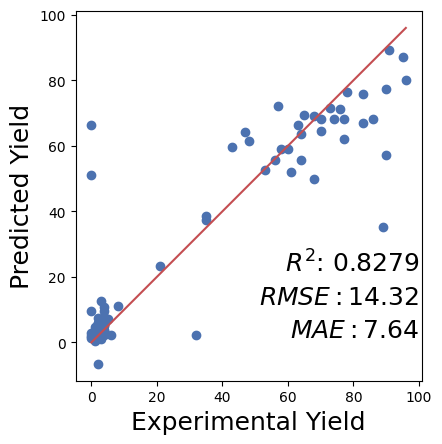

In [4]:
df3 = pd.read_csv('final_with_y_pred_weighted_mean.csv')

y_test = df3['yield']
y_pred = df3['y_pred_mean']

mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
# print(fr'R^2: {r2_test:.4f}')
# print(fr'MAE:{mae_test:.4f}')
# print(fr'RMSE: {rmse_test:.4f}')
colors = sns.color_palette("deep")
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(y_test, y_pred, color=colors[0], label='Test' )
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color=colors[3], label='Perfect Prediction')
plt.xlabel('Experimental Yield', fontsize=18)
plt.ylabel('Predicted Yield', fontsize=18)
plt.grid(False)
plt.text(100, 0, fr"$MAE: {mae_test:.2f}$", fontsize=18, ha='right', va='bottom')
plt.text(100, 10, fr"$RMSE: {rmse_test:.2f}$", fontsize=18, ha='right', va='bottom')
plt.text(100, 20, fr"$R^2$: {r2_test:.4f}", fontsize=18, ha='right', va='bottom')
plt.show()


Processing complete. Results saved to final_with_y_pred_mean.csv


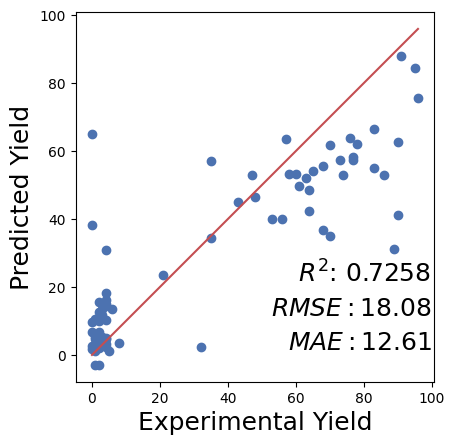

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
scaler = StandardScaler()
data = pd.read_csv('data.csv')
data_validation = pd.read_csv('validation.csv')
data_validation_1 = data_validation.drop(columns=['sub_H','sub_B','yield'])
model = SVR(C= 154.01240128578291, epsilon= 0.019791697299111212, kernel= 'rbf')
data1 = data[['delta_G_B', 'dipole_H', 'homo_B', 'Mulliken_charge_H_H', 'NPA_charge_H_H','yield']]
features = data1.select_dtypes(include=[np.number]).columns
X = data1[features].drop('yield', axis=1)
y = data1['yield']
y_pred_list = []
y_pred_weighted_list = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    model.fit(scaler.fit_transform(X_train), y_train)
    y_pred = model.predict(scaler.fit_transform(data_validation_1))
    y_pred_list.append(y_pred)

# Output the number of rows of data_validation
import numpy as np
# Convert predictions to numpy arrays
y_pred_array = np.array(y_pred_list)
# Averaging of forecasts
y_pred_avg = np.mean(y_pred_array, axis=0)
data_validation_2 = data_validation_1
data_validation_2['y_pred_mean'] = y_pred_avg
data_validation_2 = pd.concat([data_validation[['sub_H', 'sub_B']], data_validation_2], axis=1)
data_validation_2.to_csv('data_validation_mean.csv', index=False)



df1 = pd.read_csv('data_validation_mean.csv')
df2 = pd.read_csv('../../final.csv')

# Ensure that both DataFrames have sub_H and sub_B columns
if 'sub_H' not in df1.columns or 'sub_B' not in df1.columns:
    raise ValueError("First CSV file missing sub_H or sub_B columns")

if 'sub_H' not in df2.columns or 'sub_B' not in df2.columns:
    raise ValueError("Second CSV file missing sub_H or sub_B columns")

# Create a mapping dictionary with sub_H and sub_B as keys
mapping_dict = df1.set_index(['sub_H', 'sub_B'])['y_pred_mean'].to_dict()

df2['y_pred_mean'] = df2.apply(lambda row: mapping_dict.get((row['sub_H'], row['sub_B']), None), axis=1)
df2.to_csv('final_with_y_pred_mean.csv', index=False)
print("Processing complete. Results saved to final_with_y_pred_mean.csv")

df3 = pd.read_csv('final_with_y_pred_mean.csv')
y_test = df3['yield']
y_pred = df3['y_pred_mean']

# results charts

mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
# print(fr'R^2: {r2_test:.4f}')
# print(fr'MAE:{mae_test:.4f}')
# print(fr'RMSE: {rmse_test:.4f}')
colors = sns.color_palette("deep")
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(y_test, y_pred, color=colors[0], label='Test' )
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color=colors[3], label='Perfect Prediction')
plt.xlabel('Experimental Yield', fontsize=18)
plt.ylabel('Predicted Yield', fontsize=18)
plt.grid(False)
plt.text(100, 0, fr"$MAE: {mae_test:.2f}$", fontsize=18, ha='right', va='bottom')
plt.text(100, 10, fr"$RMSE: {rmse_test:.2f}$", fontsize=18, ha='right', va='bottom')
plt.text(100, 20, fr"$R^2$: {r2_test:.4f}", fontsize=18, ha='right', va='bottom')
plt.show()
